# Smith chart domains and normalization

`pysmithchart` can plot several different *domains* on the same Smith chart projection.
The domain determines **what you pass to `ax.plot()` / `ax.scatter()` / `ax.text()`** and how the library converts that data internally for display.

This notebook explains each domain and shows small, self-contained examples.

In [2]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

import pysmithchart
from pysmithchart import IMPEDANCE_DOMAIN, ADMITTANCE_DOMAIN, REFLECTANCE_DOMAIN, ABSOLUTE_DOMAIN
from pysmithchart import utils

## Domain quick reference

The Smith chart itself is drawn in terms of **normalized impedance**

$$
z = \frac{Z}{Z_0} = r + jx
$$

but users naturally work with different quantities (ohms, siemens, reflection coefficient).
`pysmithchart` supports these through a `domain=` choice.

| Domain constant | What you pass to plotting calls | Internal conversion (conceptual) | Typical use |
|---|---|---|---|
| `IMPEDANCE_DOMAIN` *(default)* | $Z$ in **ohms** | $z = Z/Z_0$ | Most RF matching, measured impedances |
| `ABSOLUTE_DOMAIN` | $z$ normalized (dimensionless) | use as-is | Teaching with normalized $r+jx$, analytical work |
| `REFLECTANCE_DOMAIN` | $\Gamma$ (a.k.a. S11), complex | $z = (1+\Gamma)/(1-\Gamma)$ | VNAs / S-parameter workflows |
| `ADMITTANCE_DOMAIN` | $Y$ in **siemens** | $z = \frac{1}{Y Z_0}$ | Admittance-based matching, dual networks |

Domains let you supply the quantity you naturally have: $Z$, $z$, $Y$, or $\Gamma$.

### How to set the domain

You can set the domain per axes:

```python
ax = plt.subplot(111, projection="smith", domain=ABSOLUTE_DOMAIN)
```

or per plotting call (overrides the default):

```python
ax.plot(Γ, domain=REFLECTANCE_DOMAIN)
ax.text(z.real, z.imag, "label", domain=IMPEDANCE_DOMAIN)
```

## Choosing the right domain

Use this decision rule:

- If you have **impedance values in ohms**, use **`IMPEDANCE_DOMAIN`** and set `Z0`.
- If you are working in **normalized** $z=r+jx$, use **`ABSOLUTE_DOMAIN`**.
- If you have **S11 / Γ** from a VNA or simulation, use **`REFLECTANCE_DOMAIN`**.
- If you have **admittance values** in siemens, use **`ADMITTANCE_DOMAIN`**.

You do **not** need to change the package default to use these: you can switch domains where it is most natural.

## A single physical load shown four ways

We will use the same physical load, and plot it using each domain.

- Reference impedance: `Z0 = 50 Ω`
- Load impedance: `ZL = 25 + j25 Ω`

From these we can compute:
- normalized impedance: `z = ZL / Z0`
- admittance: `Y = 1 / ZL`
- reflection coefficient: `Γ = (ZL - Z0) / (ZL + Z0)`

In [6]:
Z0 = 50
ZL = 30 + 1j * 30

z_norm = ZL / Z0
Y = 1 / ZL
Gamma = utils.calc_gamma(Z0, ZL)

Z0, ZL, z_norm, Y, Gamma

(50,
 (30+30j),
 (0.6+0.6j),
 (0.016666666666666666-0.016666666666666666j),
 (-0.0958904109589041+0.410958904109589j))

### 1) `IMPEDANCE_DOMAIN`: pass **ohms** (library normalizes by $Z_0$)

This is the default domain. You pass `Z` in ohms; `pysmithchart` divides by `Z0` internally.

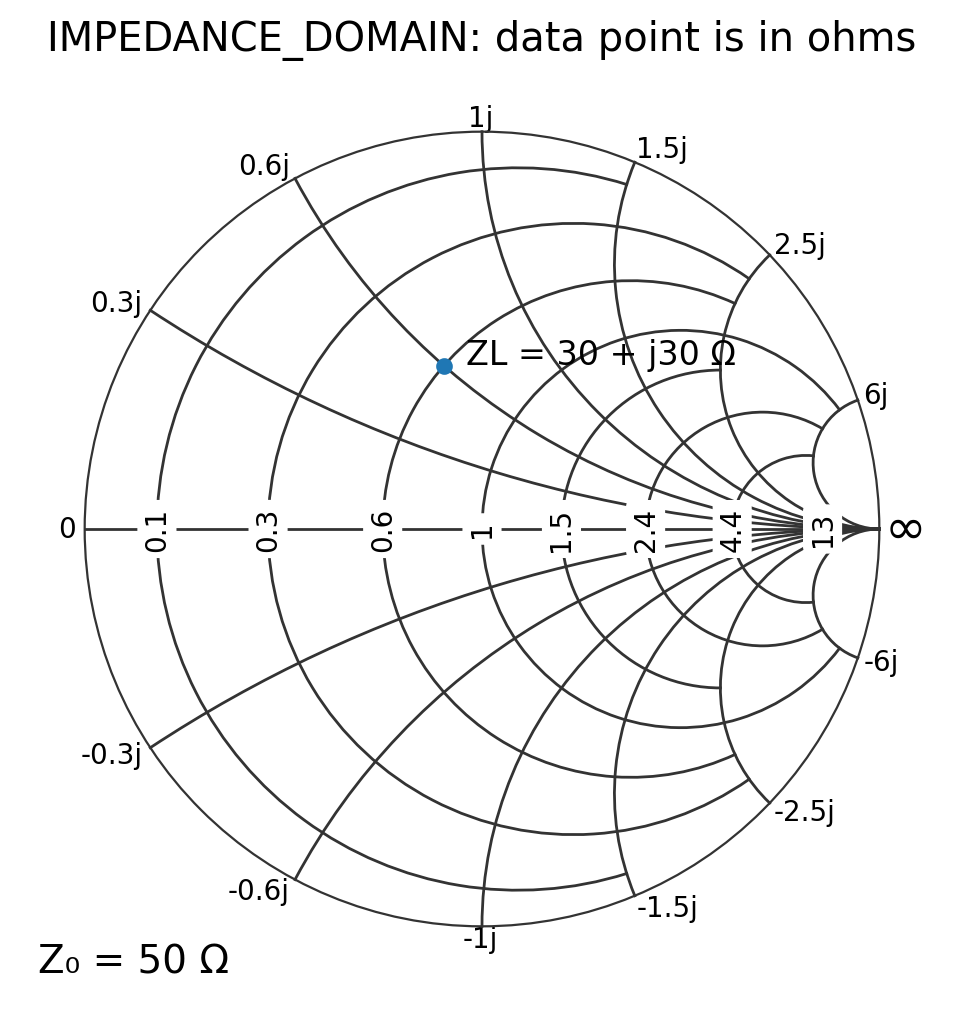

In [7]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", Z0=Z0)

ax.plot([ZL], marker="o", linestyle="")
ax.text(ZL.real + 3, ZL.imag + 3, f"ZL = {ZL.real:.0f} + j{ZL.imag:.0f} Ω")

ax.set_title("IMPEDANCE_DOMAIN: data points are in ohms")
plt.show()

### 2) `ABSOLUTE_DOMAIN`: pass **normalized z** (dimensionless)

Here you pass `z = Z/Z0` directly. These values appear right where you expect them on the grid

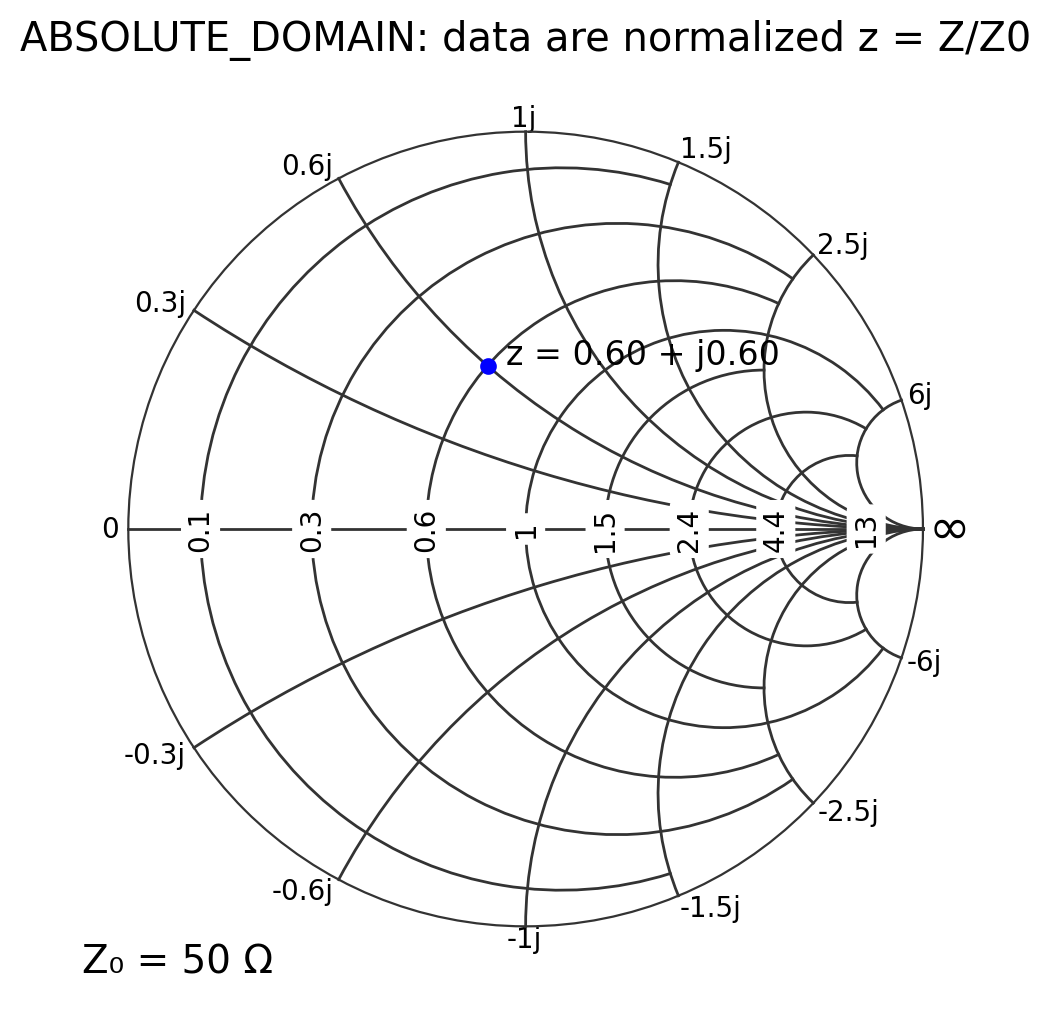

In [11]:
offset = 0.05 + 0.05j

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=ABSOLUTE_DOMAIN)

ax.plot(z_norm, "bo")
ax.text(z_norm + offset, f"z = {z_norm.real:.2f} + j{z_norm.imag:.2f}")

ax.set_title("ABSOLUTE_DOMAIN: data are normalized z = Z/Z0")
plt.show()

### 3) `REFLECTANCE_DOMAIN`: pass **Γ (S11)**

If you have S-parameters from a VNA or simulator, you might start with Γ directly.

Notes:
- Only points inside the unit circle (|Γ| ≤ 1) are visible on the chart.
- `pysmithchart` internally converts Γ to normalized impedance using the inverse Möbius transform:
  $z = (1+\Gamma)/(1-\Gamma)$.

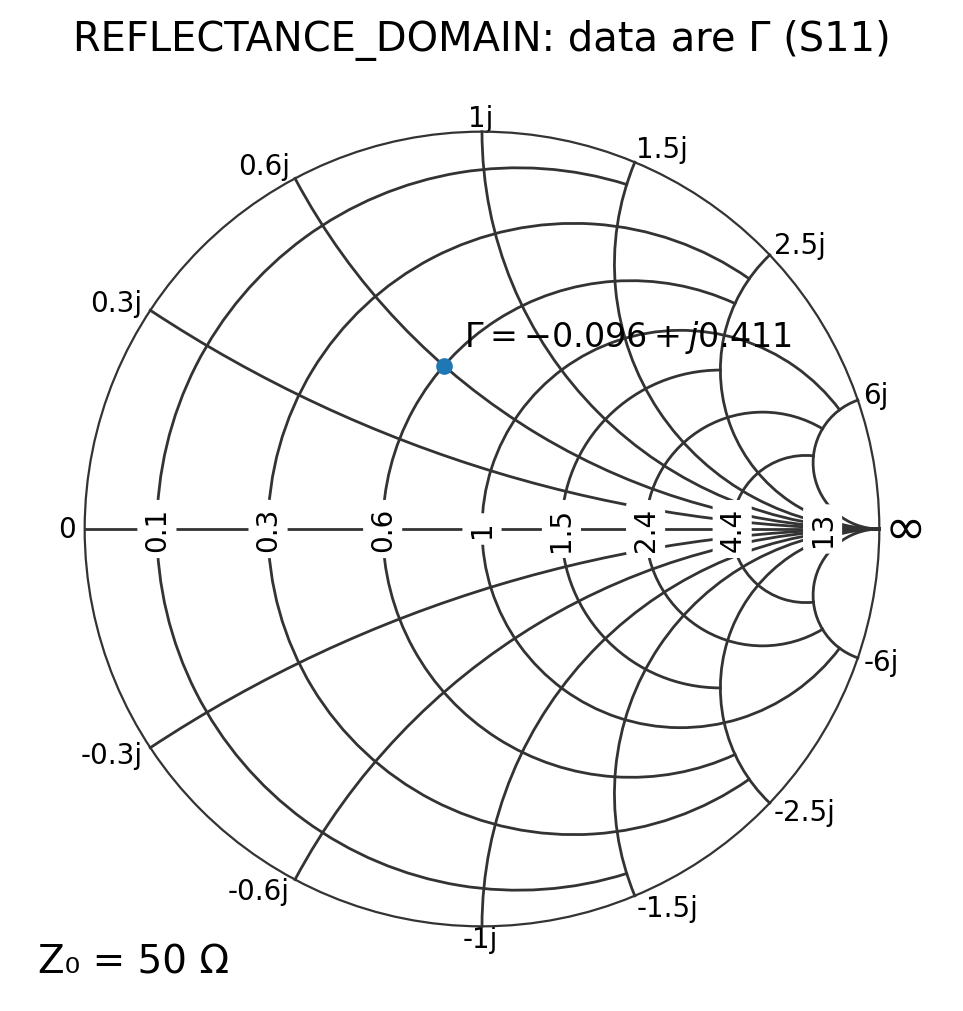

In [13]:
offset = 0.05 + 0.05j

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma, marker="o", linestyle="")
ax.text(Gamma + offset, rf"$\Gamma = {Gamma.real:.3f} + j{Gamma.imag:.3f}$")

ax.set_title("REFLECTANCE_DOMAIN: data are Γ (S11)")
plt.show()

### 4) `ADMITTANCE_DOMAIN`: pass **Y in siemens**

Admittance plotting is useful for “dual” matching workflows (e.g., shunt elements).

Internally, `pysmithchart` converts `Y` to normalized impedance using:
$z = \frac{1}{Y Z_0}$

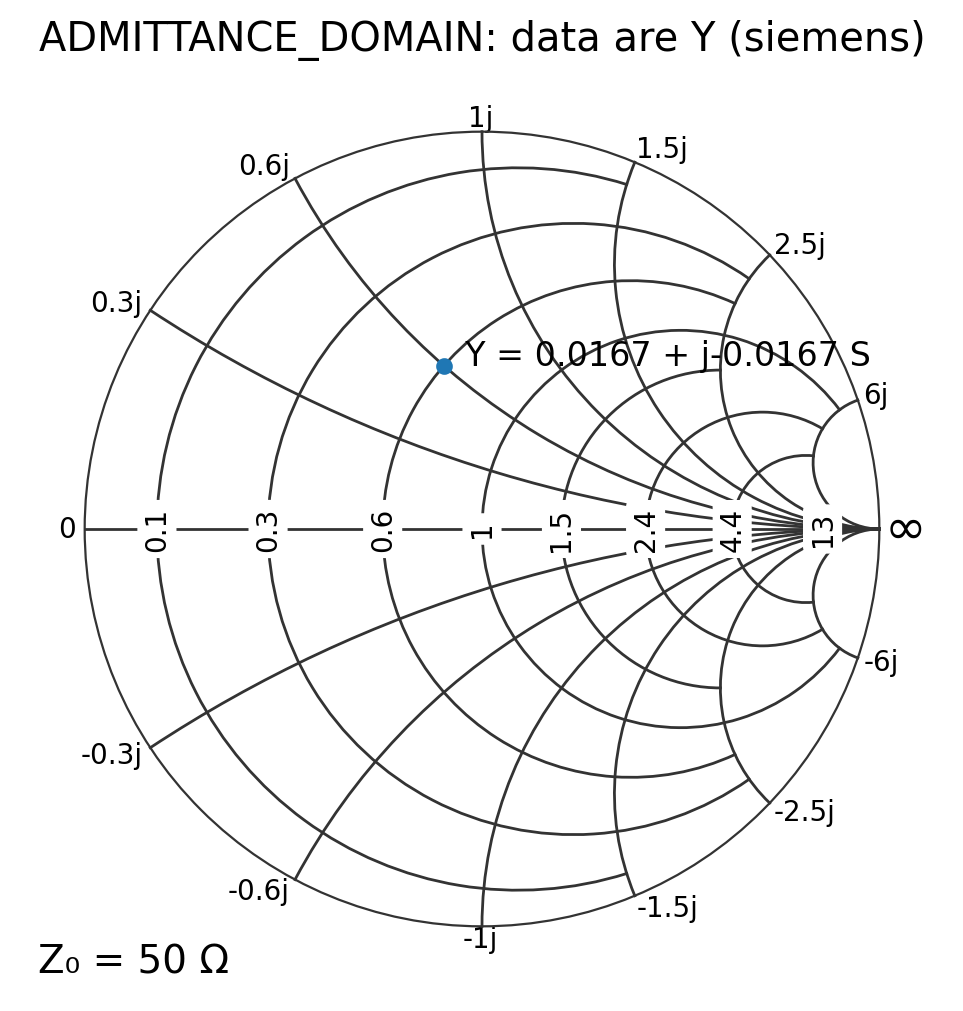

In [28]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=ADMITTANCE_DOMAIN)

ax.plot(Y, marker="o", linestyle="")
ax.text(Y, f"  Y = {Y.real:.4f} + j{Y.imag:.4f} S")

ax.set_title("ADMITTANCE_DOMAIN: data are Y (siemens)")
plt.show()

## What about `ax.text()` and `ax.annotate()`?

`pysmithchart` applies the same domain logic to `text()` and `annotate()` as it does to `plot()`.

Both forms below work fine.

* `ax.text(z, label, ...)` 
* `ax.text(x, y, label, ...)`

* `ax.annotate(z, label, ...)` 
* `ax.annotate(x, y, label, ...)`
 
That means:

- In `IMPEDANCE_DOMAIN`, `ax.text(z, ...)` expects `z` in **ohms**
- In `ABSOLUTE_DOMAIN`, `z` is **normalized** 
- In `REFLECTANCE_DOMAIN`, `x` and `y` are (Re{Γ}, Im{Γ}).
- In `ADMITTANCE_DOMAIN`, `x` and `y` are (Re{Y}, Im{Y}) in siemens.

You can always be explicit by passing `domain=...` to the text call.

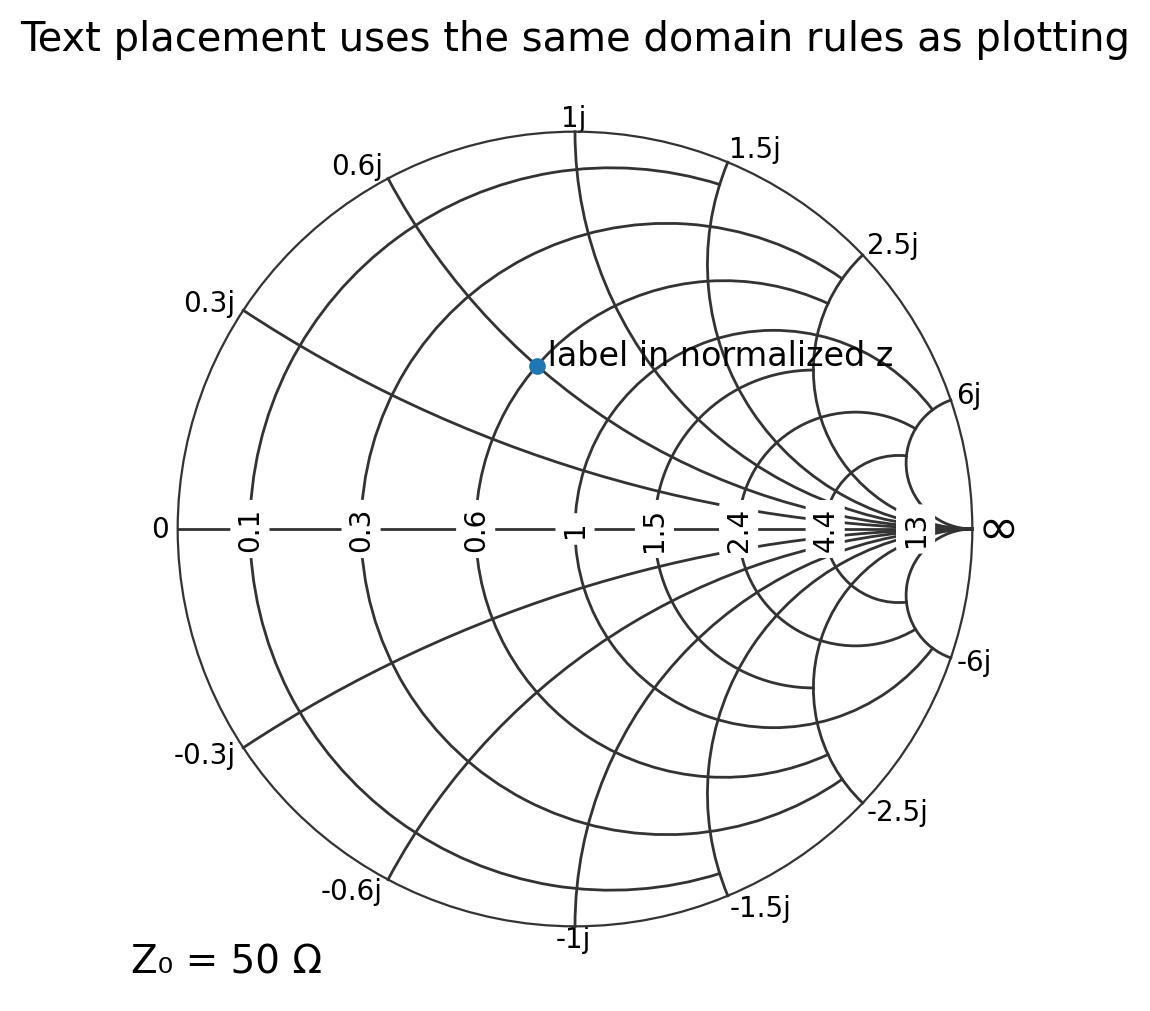

In [33]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", Z0=Z0)

ax.plot(ZL, marker="o", linestyle="")
ax.text(z_norm, " label in normalized z", domain=ABSOLUTE_DOMAIN)

ax.set_title("Text placement uses the same domain rules as plotting")
plt.show()